In [ ]:
# 作成者：望月さん

In [1]:
#データ操作用
import numpy as np
import pandas as pd
#アニメーション作成用
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from copy import deepcopy

from mpl_toolkits.axes_grid1 import Divider, Size 
from mpl_toolkits.axes_grid1.mpl_axes import Axes 

In [47]:
#シミュレーション環境の設定

WIDTH = 500#グラフ領域の幅(px)
HEIGHT = 500#グラフ領域の高さ(px)
SIZE = 5#グラフの目盛りの最大値・最小値

#目盛りは最大値5、最小値-5で10目盛り
#グラフ領域の幅と高さは500pxなので、1pxあたり0.02目盛りとなる

AGENT_SIZE = 0.1#エージェントの半径(目盛り) = 5px
AGENT = 25#エージェントの数
COLOR = [] #エージェントの色
for i in range(AGENT):
    COLOR.append("blue")

VIEW = 1#視野の半径(目盛り) = 50px:エージェント5体分
VIEWING_ANGLE = 360#視角

GOAL_VEC = 0.06#ゴールベクトルの大きさ(目盛り)
SIMPLE_AVOID_VEC = 0.06#単純回避での回避ベクトルの大きさ(目盛り)
DYNAMIC_AVOID_VEC = 0.06#動的回避での回避ベクトルの最大値(目盛り)

TRIAL = 1#試行回数
STEP = 500#1回の試行で動かすステップの回数
INTERVAL = 100#100msごとにグラフを更新してアニメーションを作成

METHOD = 0#移動方法:0が単純回避で1が動的回避

#妨害指標の4係数は標準化したやつを使う
a1 =-5.145
#-0.034298
b1 = 3.348
#3.348394
c1 =4.286
#4.252840
d1 = -13.689
#-0.003423

In [48]:
def calc_rad(pos2, pos1):#pos1からpos2のベクトルの角度を返す
    return np.arctan2(pos2[1] - pos1[1], pos2[0] - pos1[0])

def rotate_vec(vec, rad):#ベクトルをradだけ回転させる
    return np.dot( np.array([[np.cos(rad), -np.sin(rad)], [np.sin(rad), np.cos(rad)]]),vec.T).T

#シミュレーションに関わるクラス
class simulation():
    def __init__(self):
        
        #all_agentは全エージェントの座標を記録、all_agent2はゴールの計算用、first_agentは初期位置記録用
        self.all_agent = []
        self.all_agent2 = []
        self.first_agent = []
        self.agent_goal = []
        self.first_pos =[]
        
        for n in range(AGENT):
            #グラフ領域の中からランダムに座標を決定
            pos = np.random.uniform(-SIZE,SIZE,2)
            vel = np.random.uniform(-SIZE,SIZE,2)
            
            #座標(0,0)から座標velへのベクトルがエージェントの初期速度になる
            #self.all_agentの1つの要素に1体のエージェントの位置と速度が記録
            self.all_agent.append({'p':pos, 'v':rotate_vec(np.array([GOAL_VEC, 0]), calc_rad(vel, np.array([0,0])))})

        #初期位置と初期速度をコピー
        self.all_agent2 = deepcopy(self.all_agent)
        self.first_agent = deepcopy(self.all_agent)
        
        #エージェントの初期位置を保存
        for i in range(AGENT):
            self.first_pos.append(self.first_agent[i]['p'])
        
        #エージェントにゴールを8ずつ設定
        for i in range(AGENT):
            goals = []
            for j in range(8):
                goals.append(self.findGoal(self.all_agent2[i]))
                
            self.agent_goal.append(goals)
             
            
        #エージェント間の距離を記録するリスト
        self.dist = np.zeros([AGENT,AGENT])
        
        #ゴールした回数を記録するリスト
        self.goal_count = []
        for i in range(AGENT):
            self.goal_count.append(0)

        #はみ出た時用のゴール
        self.goal_temp = np.zeros([AGENT,2])
        
        #完了時間を測るための変数
        self.start_step = np.zeros([AGENT])
        self.goal_step = np.zeros([AGENT])
        self.start_pos = self.first_pos
        self.goal_pos = np.zeros([AGENT,2])
         
        #完了時間を記録するリスト
        self.completion_time = []

            

    #ゴールの計算
    #エージェントが初期速度のまま進んだ場合に通過する、グラフ領域の境界線の座標
    def findGoal(self,agent):
        
        while True:
            
            #x座標がグラフ領域を超える
            if((agent['p'] + agent['v'])[0] < -SIZE):
                #超えた時の座標をゴールとする
                goal = agent['p'] + agent['v']
                
                #y座標も同時にサイズを超えるかつyが正
                if(goal[1] > SIZE - 0.1):
                    #ゴールの座標がグラフ領域の角にならないように調整
                    goal[1] =  goal[1] - 0.1
                    print("調整入りました")
                    
               #y座標も同時にサイズを超えるかつyが負
                elif(goal[1] < -SIZE + 0.1):
                    #ゴールの座標がグラフ領域の角にならないように調整
                    goal[1] = goal[1] + 0.1
                    print("調整入りました")
                    
                goal[0] = -SIZE
                #端に到達したエージェントを、反対側の端に移動させる
                agent['p'][0] = SIZE + ((agent['p'] + agent['v'])[0] + SIZE)
                break
                        
            elif((agent['p'] + agent['v'])[0] > SIZE):
                goal = agent['p'] + agent['v']
                
                #y座標も同時にサイズを超えるかつyが正
                if(goal[1] > SIZE - 0.1):
                    goal[1] = goal[1] - 0.1
                    print("調整入りました")

               #y座標も同時にサイズを超えるかつyが負
                elif(goal[1] < -SIZE + 0.1):
                    goal[1] = goal[1] + 0.1
                    print("調整入りました")
                    
                goal[0] = SIZE
                agent['p'][0] = -SIZE + ((agent['p']+agent['v'])[0] - SIZE)
                break
                
                
            #y座標がグラフ領域を超える
            elif((agent['p']+agent['v'])[1] < -SIZE):
                #超えた時の座標をゴールとする
                goal = agent['p']+agent['v']
                goal[1] = -SIZE
                
                agent['p'][1] = SIZE + ((agent['p']+agent['v'])[1] + SIZE)
                break
                                        
            elif((agent['p']+agent['v'])[1] > SIZE):
                goal = agent['p']+agent['v']
                goal[1] = SIZE
                
                agent['p'][1] = -SIZE + ((agent['p']+agent['v'])[1] - SIZE)
                break
                
            #エージェントを初期速度のまま動かす
            agent['p'] = agent['p'] + agent['v']

        return goal

        
    #距離の計算
    def distance(self):
        for i in range(AGENT):
            for j in range(AGENT):
                d = self.all_agent[i]['p'] - self.all_agent[j]['p']
                #エージェント間の距離を算出、エージェントのサイズも考慮
                self.dist[i][j] = np.linalg.norm(d) - 2 * AGENT_SIZE
                
                
    #指定した距離より接近したエージェントの数を返す
    def approach_detect(self,dist):
        self.distance()
        approach_agent = []
        
        #distより接近したエージェントの数を記録
        for t in range(AGENT):
            visible_agents = [i for i,x in enumerate(self.dist[t]) if x != -(0.2) and x < dist]
            approach_agent.append(len(visible_agents))
            
        return approach_agent
    
    
    #単純な回避ベクトルの生成
    def simple_avoidance(self,num):
        self.distance()
        #near_agentsは360度の視野に入ったエージェント、visible_agentsは視野を狭めた場合に視野に入ったエージェント
        near_agents = [i for i,x in enumerate(self.dist[num]) if x != -(0.2) and x < VIEW]
        visible_agents =[]
        #回避ベクトル
        avoid_vec = np.zeros(2)
        
        if not near_agents:
            return avoid_vec
        
        #ゴールベクトルの角度を算出する
        goal_angle = np.degrees(calc_rad(self.agent_goal[num][self.goal_count[num]],self.all_agent[num]['p']))

        for i in near_agents:
            #近づいたエージェントとの角度を算出
            agent_angle = np.degrees(calc_rad(self.all_agent[i]['p'],self.all_agent[num]['p']))
            
            #近づいたエージェントとの角度とゴールベクトルの角度の差を計算
            angle_difference = abs(goal_angle - agent_angle)
            
            if angle_difference > 180:
                angle_difference = 360 - angle_difference
                
            #視野に入っているエージェントをvisible_agentsに追加
            if angle_difference <= VIEWING_ANGLE / 2:
                visible_agents.append(i)
                
        if not visible_agents: 
            return avoid_vec
            
        for i in visible_agents:
            #dは視界に入ったエージェントに対して反対方向のベクトル
            d = self.all_agent[num]['p'] - self.all_agent[i]['p']
            d = d / (self.dist[num][i] + 2 * AGENT_SIZE)#大きさ1のベクトルにする
            d = d * SIMPLE_AVOID_VEC#大きさを固定値にする
            
            avoid_vec += d#回避ベクトルを合成する
            
        #ベクトルの平均を出す
        return avoid_vec / len(visible_agents)
    
    
    #動的回避ベクトルの生成
    def dynamic_avoidance(self,num,goal):
        self.distance()
        near_agents = [i for i,x in enumerate(self.dist[num]) if x != -(0.2) and x < VIEW]
        visible_agents =[]
        avoid_vec = np.zeros(2)
        
        if not near_agents:
            return avoid_vec
        
        #ゴールベクトルの角度を算出する
        goal_angle = np.degrees(calc_rad(self.agent_goal[num][self.goal_count[num]],self.all_agent[num]['p']))

        for i in near_agents:
            #近づいたエージェントとの角度を算出
            agent_angle = np.degrees(calc_rad(self.all_agent[i]['p'],self.all_agent[num]['p']))
            
            #近づいたエージェントとの角度とゴールベクトルの角度の差を計算
            angle_difference = abs(goal_angle - agent_angle)

            if angle_difference > 180:
                angle_difference = 360 - angle_difference
            
            #視界に入ったエージェントをvisible_agentsに追加
            if angle_difference <= VIEWING_ANGLE / 2:
                visible_agents.append(i)
                
        if not visible_agents:
            return avoid_vec
            
        
        for i in visible_agents:
            #視野の中心にいるエージェントの位置と速度
            self.agent_pos = self.all_agent[num]['p']
            self.agent_vel = self.all_agent[num]['v']
            #視野に入ったエージェントの位置と速度
            self.visible_agent_pos = self.all_agent[i]['p']
            self.visible_agent_vel = self.all_agent[i]['v']

            
            dist_former = self.dist[num][i]
            
            t = 0
            #2体のエージェントを1ステップ動かして距離を測定
            self.agent_pos =  self.agent_pos + self.agent_vel
            self.visible_agent_pos = self.visible_agent_pos + self.visible_agent_vel
            d = self.agent_pos - self.visible_agent_pos
            dist_latter = np.linalg.norm(d) - 2 * AGENT_SIZE
            
            
            #視界に入った時が最も近い場合
            if dist_former < dist_latter:
                tcpa = 0
                if dist_former < 0:
                    dcpa = 0 #最も近い距離で接触している場合はdcpaは0とみなす
                else:
                    dcpa = dist_former * 50 #単位をピクセルに変換
                    
                    
            #2者間距離の最小値が出るまでエージェントを動かす
            else:
                while dist_former > dist_latter:
                    dist_former = dist_latter
                    t += INTERVAL
                    self.agent_pos =  self.agent_pos + self.agent_vel
                    self.visible_agent_pos = self.visible_agent_pos + self.visible_agent_vel
                    d = self.agent_pos - self.visible_agent_pos
                    dist_latter = np.linalg.norm(d) - 2 * AGENT_SIZE
                    
                if dist_former < 0:
                    dcpa = 0#最も近い距離で接触している場合はdcpaは0とみなす
                else:
                    dcpa = dist_former * 50 #単位をピクセルに変換
                    
                tcpa = t


            #ブレーキ指標の算出
            braking_index = (1/(1 + np.exp(-c1 - d1 * (tcpa/4000)))) * (1/(1 + np.exp(-b1 - a1 * (dcpa/50))))
            
            #dは視界に入ったエージェントに対して反対方向のベクトル
            d = self.all_agent[num]['p'] - self.all_agent[i]['p']
            d = d / (self.dist[num][i] + 2 * AGENT_SIZE)#ベクトルの大きさを1にする
            d = d * braking_index#ブレーキ指標の値を反映
            d = d * DYNAMIC_AVOID_VEC#ベクトルの最大値を決定
            
            avoid_vec += d#ベクトルの合成
        
        #ベクトルの平均を出す
        return avoid_vec / len(visible_agents)
    
    
    #シミュレーション
    def simulate(self,step):
        
        #単純回避
        if METHOD == 0:
            for i in range(AGENT):
                #はみ出た時用のゴールが設定されていない
                #通常のゴールに向かうベクトルと、回避ベクトルを足したものが速度になる
                if(self.goal_temp[i][0] == 0 and self.goal_temp[i][1] == 0):
                    self.all_agent[i]['v'] = rotate_vec(np.array([GOAL_VEC, 0]), calc_rad(self.agent_goal[i][self.goal_count[i]], self.all_agent[i]['p'])) + self.simple_avoidance(i)        

                #はみ出た時用のゴールが設定されている
                #はみ出た時用のゴールに向かうベクトルと、回避ベクトルを足したものが速度になる
                else:
                    self.all_agent[i]['v'] = rotate_vec(np.array([GOAL_VEC, 0]), calc_rad(self.goal_temp[i], self.all_agent[i]['p'])) + self.simple_avoidance(i)            
        
        #動的回避
        if METHOD == 1:
            for i in range(AGENT):
                if(self.goal_temp[i][0] == 0 and self.goal_temp[i][1] == 0):
                    self.all_agent[i]['v'] = rotate_vec(np.array([GOAL_VEC, 0]), calc_rad(self.agent_goal[i][self.goal_count[i]], self.all_agent[i]['p'])) + self.dynamic_avoidance(i,self.agent_goal[i][self.goal_count[i]])
                else:
                    self.all_agent[i]['v'] = rotate_vec(np.array([GOAL_VEC, 0]), calc_rad(self.goal_temp[i], self.all_agent[i]['p'])) + self.dynamic_avoidance(i,self.goal_temp[i])            
        
        
        for i in range(AGENT):
            #x座標が左端をこえる
            if((self.all_agent[i]['p']+self.all_agent[i]['v'])[0] < -SIZE):
                #ゴールに到着
                if(self.all_agent[i]['p'][0] > self.agent_goal[i][self.goal_count[i]][0] - 0.1 and self.all_agent[i]['p'][0] < self.agent_goal[i][self.goal_count[i]][0] + 0.1 and self.all_agent[i]['p'][1] > self.agent_goal[i][self.goal_count[i]][1] - 0.1 and self.all_agent[i]['p'][1] < self.agent_goal[i][self.goal_count[i]][1] + 0.1):
                    
                    #通常のゴールに到着
                    if(self.goal_temp[i][0] == 0 and self.goal_temp[i][1] == 0):
                        #完了時間を算出
                        completion_time = self.calc_completion_time(i,step)
                        if not completion_time == None:
                            self.completion_time.append(completion_time)
                        #ゴールした回数を更新
                        self.goal_count[i] = self.goal_count[i] + 1
                        
                    #はみ出た時用のゴールに到着
                    else:
                        #はみ出た時用のゴールを初期化
                        self.goal_temp[i][0] = 0
                        self.goal_temp[i][1] = 0
                        
                #ゴールに到着せず、境界を超える  
                else:
                    #はみ出た時用のゴールが設定されていない
                    if(self.goal_temp[i][0] == 0 and self.goal_temp[i][1] == 0):
                        #はみ出た時用のゴールを設定
                        self.goal_temp[i][0] = self.agent_goal[i][self.goal_count[i]][0] + 2 * SIZE
                        self.goal_temp[i][1] = self.agent_goal[i][self.goal_count[i]][1]
                        
                    #はみ出た時用のゴールが設定されている
                    else:
                        #はみ出た時用のゴールを初期化
                        self.goal_temp[i][0] = 0
                        self.goal_temp[i][1] = 0
                
                #エージェントを反対の端へ移動
                self.all_agent[i]['p'][0] = SIZE + ((self.all_agent[i]['p']+self.all_agent[i]['v'])[0] + SIZE)
        
            
            #x座標が右端をこえる
            elif((self.all_agent[i]['p']+self.all_agent[i]['v'])[0] > SIZE):
                
                #ゴール判定
                if(self.all_agent[i]['p'][0] > self.agent_goal[i][self.goal_count[i]][0] - 0.1 and self.all_agent[i]['p'][0] < self.agent_goal[i][self.goal_count[i]][0] + 0.1 and self.all_agent[i]['p'][1] > self.agent_goal[i][self.goal_count[i]][1] - 0.1 and self.all_agent[i]['p'][1] < self.agent_goal[i][self.goal_count[i]][1] + 0.1):
                    
                    #ゴールが調整されているか確認
                    if(self.goal_temp[i][0] == 0 and self.goal_temp[i][1] == 0):
                        #完了時間を算出
                        completion_time = self.calc_completion_time(i,step)
                        if not completion_time == None:
                            self.completion_time.append(completion_time)
                        self.goal_count[i] = self.goal_count[i] + 1
                    else:
                        #はみ出た時用のゴールを初期化
                        self.goal_temp[i][0] = 0
                        self.goal_temp[i][1] = 0
                        
                else:
                    #ゴールが調整されているか確認
                    if(self.goal_temp[i][0] == 0 and self.goal_temp[i][1] == 0):
                        #境界をこえた用のゴールを設定
                        self.goal_temp[i][0] = self.agent_goal[i][self.goal_count[i]][0] + (-2 * SIZE)
                        self.goal_temp[i][1] = self.agent_goal[i][self.goal_count[i]][1]
                    else:
                        #はみ出た時用のゴールを初期化
                        self.goal_temp[i][0] = 0
                        self.goal_temp[i][1] = 0
                        
                self.all_agent[i]['p'][0] = -SIZE + ((self.all_agent[i]['p']+self.all_agent[i]['v'])[0] - SIZE)

                
            #y座標が下をこえる
            elif((self.all_agent[i]['p']+self.all_agent[i]['v'])[1] < -SIZE):
                
                #ゴール判定
                if(self.all_agent[i]['p'][0] > self.agent_goal[i][self.goal_count[i]][0] - 0.1 and self.all_agent[i]['p'][0] < self.agent_goal[i][self.goal_count[i]][0] + 0.1 and self.all_agent[i]['p'][1] > self.agent_goal[i][self.goal_count[i]][1] - 0.1 and self.all_agent[i]['p'][1] < self.agent_goal[i][self.goal_count[i]][1] + 0.1):
                    
                    #ゴールが調整されているか確認
                    if(self.goal_temp[i][0] == 0 and self.goal_temp[i][1] == 0):
                        #完了時間を算出
                        completion_time = self.calc_completion_time(i,step)
                        if not completion_time == None:
                            self.completion_time.append(completion_time)
                        self.goal_count[i] = self.goal_count[i] + 1
                    else:
                        #はみ出た時用のゴールを初期化
                        self.goal_temp[i][0] = 0
                        self.goal_temp[i][1] = 0
                        
                else:
                    #ゴールが調整されているか確認
                    if(self.goal_temp[i][0] == 0 and self.goal_temp[i][1] == 0):
                        #境界をこえた用のゴールを設定
                        self.goal_temp[i][0] = self.agent_goal[i][self.goal_count[i]][0]
                        self.goal_temp[i][1] = self.agent_goal[i][self.goal_count[i]][1] + 2 * SIZE
                    else:        
                        #はみ出た時用のゴールを初期化
                        self.goal_temp[i][0] = 0
                        self.goal_temp[i][1] = 0
                        
                self.all_agent[i]['p'][1] = SIZE + ((self.all_agent[i]['p']+self.all_agent[i]['v'])[1] + SIZE)
                
            #y座標が上をこえる     
            elif((self.all_agent[i]['p']+self.all_agent[i]['v'])[1] > SIZE):
                
                #ゴール判定
                if(self.all_agent[i]['p'][0] > self.agent_goal[i][self.goal_count[i]][0] - 0.1 and self.all_agent[i]['p'][0] < self.agent_goal[i][self.goal_count[i]][0] + 0.1 and self.all_agent[i]['p'][1] > self.agent_goal[i][self.goal_count[i]][1] - 0.1 and self.all_agent[i]['p'][1] < self.agent_goal[i][self.goal_count[i]][1] + 0.1):
                    
                    #ゴールが調整されているか確認
                    if(self.goal_temp[i][0] == 0 and self.goal_temp[i][1] == 0):
                        #完了時間を算出
                        completion_time = self.calc_completion_time(i,step)
                        if not completion_time == None:
                            self.completion_time.append(completion_time)
                        self.goal_count[i] = self.goal_count[i] + 1
                    else:
                        #はみ出た時用のゴールを初期化
                        self.goal_temp[i][0] = 0
                        self.goal_temp[i][1] = 0
                        
                else:
                    #ゴールが調整されているか確認
                    if(self.goal_temp[i][0] == 0 and self.goal_temp[i][1] == 0):
                        #境界をこえた用のゴールを設定
                        self.goal_temp[i][0] = self.agent_goal[i][self.goal_count[i]][0]
                        self.goal_temp[i][1] = self.agent_goal[i][self.goal_count[i]][1] + (-2 * SIZE)
                    else:
                        #はみ出た時用のゴールを初期化
                        self.goal_temp[i][0] = 0
                        self.goal_temp[i][1] = 0
                        

                self.all_agent[i]['p'][1] = -SIZE + ((self.all_agent[i]['p']+self.all_agent[i]['v'])[1] - SIZE)

                
        for i in range(AGENT):
            #移動後の座標を確定      
            self.all_agent[i]['p'] =  self.all_agent[i]['p'] + self.all_agent[i]['v']
            
        
            
    #完了時間を記録
    def calc_completion_time(self,num,now_step):
        
        #一回のゴールにおける初めのステップと終わりのステップを記録
        self.start_step[num] = self.goal_step[num] + 1
        self.goal_step[num] = now_step
        
        #一回目のゴール
        if(self.start_step[num] == 1):
            #一回目のゴールにおける、ゴール位置を記録
            self.goal_pos[num] = self.agent_goal[num][self.goal_count[num]]
            
        #一回目以降のゴール
        else:
            #前回のゴールが左端にあるとき
            if(self.goal_pos[num][0] == -SIZE):
                #スタート位置、ゴール位置を記録
                self.start_pos[num][0] = self.goal_pos[num][0] + 2 * SIZE
                self.start_pos[num][1] = self.goal_pos[num][1]
                self.goal_pos[num] = self.agent_goal[num][self.goal_count[num]]
                
            #前回のゴールが右端にあるとき
            elif(self.goal_pos[num][0] == SIZE):
                #スタート位置、ゴール位置を記録
                self.start_pos[num][0] = self.goal_pos[num][0] + (-2 * SIZE)
                self.start_pos[num][1] = self.goal_pos[num][1]
                self.goal_pos[num] = self.agent_goal[num][self.goal_count[num]]
            
            #前回のゴールが下端にあるとき
            elif(self.goal_pos[num][1] == -SIZE):
                #スタート位置、ゴール位置を記録
                self.start_pos[num][0] = self.goal_pos[num][0]
                self.start_pos[num][1] = self.goal_pos[num][1] + 2 * SIZE
                self.goal_pos[num] = self.agent_goal[num][self.goal_count[num]]
                
            #前回のゴールが上端にあるとき
            elif(self.goal_pos[num][1] == SIZE):
                #スタート位置、ゴール位置を記録
                self.start_pos[num][0] = self.goal_pos[num][0]
                self.start_pos[num][1] = self.goal_pos[num][1] + (-2 * SIZE)
                self.goal_pos[num] = self.agent_goal[num][self.goal_count[num]]
                
        #完了時間を計算(ゴールまでのステップ/ゴールまでの距離)
        completion_time = (self.goal_step[num] - self.start_step[num] + 1) / (np.linalg.norm(self.start_pos[num] - self.goal_pos[num]))
        
        #外れ値を除外
        if(completion_time > 200):
            print("消します")
            print(completion_time)
            return None
        
        return completion_time
    
    #最後の座標から完了時間を算出(やらなくても良いかもしれない)
    def calc_last_completion_time(self,num):
        
        #初めのステップと終わりのステップを記録
        self.start_step[num] = self.goal_step[num] + 1
        self.goal_step[num] = STEP
        
        #ゴールする前に境界をはみ出ている場合
        if not(self.goal_temp[i][0] == 0 and self.goal_temp[i][1] == 0):
            #左右の境界をはみ出た
            if(abs(self.all_agent[num]['p'][0]) > abs(self.all_agent[num]['p'][1])):
                #はみ出る前に戻してあげる
                self.all_agent[num]['p'][0] = -self.all_agent[num]['p'][0]
            #上下の境界をはみ出た
            elif(abs(self.all_agent[num]['p'][0]) < abs(self.all_agent[num]['p'][1])):
                #はみ出る前に戻してあげる
                self.all_agent[num]['p'][1] = -self.all_agent[num]['p'][1]
            
        #スタート位置、ゴール位置を算出
        #前回のゴールが左端にあるとき
        if(self.goal_pos[num][0] == -SIZE):
            self.start_pos[num][0] = self.goal_pos[num][0] + 2 * SIZE
            self.start_pos[num][1] = self.goal_pos[num][1]
            self.goal_pos[num] = self.agent_goal[num][self.goal_count[num]]

        #前回のゴールが右端にあるとき
        elif(self.goal_pos[num][0] == SIZE):
            self.start_pos[num][0] = self.goal_pos[num][0] + (-2 * SIZE)
            self.start_pos[num][1] = self.goal_pos[num][1]
            self.goal_pos[num] = self.agent_goal[num][self.goal_count[num]]

        #前回のゴールが下端にあるとき
        elif(self.goal_pos[num][1] == -SIZE):
            self.start_pos[num][0] = self.goal_pos[num][0]
            self.start_pos[num][1] = self.goal_pos[num][1] + 2 * SIZE
            self.goal_pos[num] = self.agent_goal[num][self.goal_count[num]]

        #前回のゴールが上端にあるとき
        elif(self.goal_pos[num][1] == SIZE):
            self.start_pos[num][0] = self.goal_pos[num][0]
            self.start_pos[num][1] = self.goal_pos[num][1] + (-2 * SIZE)
            self.goal_pos[num] = self.agent_goal[num][self.goal_count[num]]
            
        
        #スタートからゴールまでの直線の式を計算
        #傾き
        a = (self.start_pos[num][1] - self.goal_pos[num][1])/(self.start_pos[num][0] - self.goal_pos[num][0])
        #切片
        b = -(a * self.start_pos[num][0]) + self.start_pos[num][1]
        
        #エージェントの位置を通り、スタートからゴールまでの直線に垂直な直線の式を計算
        #傾き
        c = (-1) / a
        #切片
        d = -(c * self.all_agent[num]['p'][0]) + self.all_agent[num]['p'][1]

        #2つの直線の交点を算出
        cross_x = (b - d) / (-(a - c))
        cross_y = a * cross_x + b
        cross = np.array([cross_x,cross_y])
        
        #スタートから交点までの距離を計算
        distance = np.linalg.norm(self.start_pos[num] - cross)
        
        #完了時間を計算(ゴールまでのステップ/ゴールまでの距離)
        completion_time = (self.goal_step[num] - self.start_step[num] + 1) / distance

        if(completion_time > 200 or completion_time < 10):
            print("消しました")
            print(completion_time)
            return None
        
        return completion_time

            

    #座標を送る
    def showImage(self):
        pos_array = np.zeros([2,AGENT])
        for i in range(AGENT):
            pos_array[0][i] = self.all_agent[i]['p'][0]
            pos_array[1][i] = self.all_agent[i]['p'][1]
        return pos_array



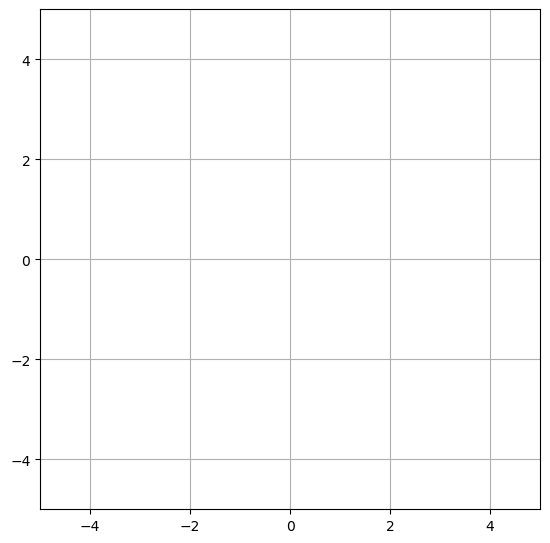

In [49]:
ax_w_px = WIDTH  #プロット領域の幅をピクセル単位で指定
ax_h_px = HEIGHT  #プロット領域の高さをピクセル単位で指定


# サイズ指定のための処理、20行目までhttps://qiita.com/code0327/items/43118813b6085dc7e3d1　を参照
fig_dpi = 100
ax_w_inch = ax_w_px / fig_dpi
ax_h_inch = ax_h_px / fig_dpi
ax_margin_inch = (0.5, 0.5, 0.5, 0.5)  # Left,Top,Right,Bottom [inch]

fig_w_inch = ax_w_inch + ax_margin_inch[0] + ax_margin_inch[2] 
fig_h_inch = ax_h_inch + ax_margin_inch[1] + ax_margin_inch[3]

fig = plt.figure( dpi=fig_dpi, figsize=(fig_w_inch, fig_h_inch))
ax_p_w = [Size.Fixed(ax_margin_inch[0]),Size.Fixed(ax_w_inch)]
ax_p_h = [Size.Fixed(ax_margin_inch[1]),Size.Fixed(ax_h_inch)]
divider = Divider(fig, (0.0, 0.0, 1.0, 1.0), ax_p_w, ax_p_h, aspect=False)
ax = Axes(fig, divider.get_position())
ax.set_axes_locator(divider.new_locator(nx=1,ny=1))
fig.add_axes(ax)



ax.set_xlim(-SIZE, SIZE)
ax.set_ylim(-SIZE, SIZE)
ax.grid(True)

In [50]:
#各シミュレーションの結果を保存する変数
row_label = []
values = []

#図のデータをまとめるもの、これを流すことでアニメーションになる
ims = []

for num in range(TRIAL):
    np.random.seed(num)
    O = simulation()


    data = []
    column_label = []
    index_label = []
    index_label.append('initial_value')

    #出力データの列のラベルを作成
    for i in range(AGENT):
        column_label.append('agent ' + str(i) + ' pos_x')
        column_label.append('agent ' + str(i) + ' pos_y')
        column_label.append('agent ' + str(i) + ' vel_x')
        column_label.append('agent ' + str(i) + ' vel_y')
    
    #衝突(距離0以下)
    for i in range(AGENT):
        column_label.append('agent ' + str(i) + ' collision')
    #視野の半分の距離まで接近
    for i in range(AGENT):
        column_label.append('agent ' + str(i) + ' half')
    #視野の四分の一の距離まで接近
    for i in range(AGENT):
        column_label.append('agent ' + str(i) + ' quarter')
    #視野の八分の一の距離まで接近
    for i in range(AGENT):
        column_label.append('agent ' + str(i) + ' one_eighth')


    #初期の位置と速度を記録
    row = []
    row = np.concatenate([O.all_agent[0]['p'],O.all_agent[0]['v']])
    #rowにはある時刻の全エージェントの位置と速度が入る
    for i in range(1,AGENT):
        row = np.concatenate([row,O.all_agent[i]['p'],O.all_agent[i]['v']])


    #衝突したエージェントの数を記録
    collision_agent = O.approach_detect(0)
    for i in range(AGENT):
        row = np.append(row,collision_agent[i])
    
    #視野の半分より接近したエージェントの数を記録
    collision_agent = O.approach_detect(0.5)
    for i in range(AGENT):
        row = np.append(row,collision_agent[i])
    
    #視野の四分の一より接近したエージェントの数を記録
    collision_agent = O.approach_detect(0.25)
    for i in range(AGENT):
        row = np.append(row,collision_agent[i])
        
    #視野の八分の一より接近したエージェントの数を記録
    collision_agent = O.approach_detect(0.125)
    for i in range(AGENT):
        row = np.append(row,collision_agent[i])
        
    #ある時刻でのエージェントの情報が記録されたrowが集まってdataとなる
    data.append(row)

    #最初に表示する図の作成
    plot_data = O.showImage()
    im=ax.scatter(*plot_data,marker="o",s=40,c=COLOR)
    ims.append([im])


    #シミュレーション
    for t in range(STEP):
        O.simulate(t + 1)
        index_label.append(t + 1)
        #どこまで進んでいるか分かる用、numは試行回数でt+1はステップ数
        print(str(num) + "  " + str(t+1))

        #シミュレーションごとに値を記録
        row = []
        row = np.concatenate([O.all_agent[0]['p'],O.all_agent[0]['v']])
        for i in range(1,AGENT):
            row = np.concatenate([row,O.all_agent[i]['p'],O.all_agent[i]['v']])

        #衝突したエージェントを記録
        collision_agent = O.approach_detect(0)
        for i in range(AGENT):
            row = np.append(row,collision_agent[i])

        collision_agent = O.approach_detect(0.5)
        for i in range(AGENT):
            row = np.append(row,collision_agent[i])
            
        collision_agent = O.approach_detect(0.25)
        for i in range(AGENT):
            row = np.append(row,collision_agent[i])

        collision_agent = O.approach_detect(0.125)
        for i in range(AGENT):
            row = np.append(row,collision_agent[i])

        data.append(row)

        #図を作成
        plot_data = O.showImage()
        im=ax.scatter(*plot_data,marker="o",s=40,c=COLOR)
        ims.append([im])
        
        goal_step = STEP
        

    #csvとしてステップごとに位置、速度、接近した回数を記録
    """
    df = pd.DataFrame(data,columns=column_label,index=index_label)
    df.to_csv('/Users/mango/卒業研究/to_csv_out_' + str(num) + '.csv')
    """
    
    #アニメーションを保存
    """
    ani = animation.ArtistAnimation(fig, ims, interval=INTERVAL, repeat=False)
    ani.save('animation.gif', writer='pillow')
    """
    
    #最後の座標から完了時間を算出
    for i in range(AGENT):
        last_completion_time = O.calc_last_completion_time(i)
        if not last_completion_time == None:
            O.completion_time.append(last_completion_time)

    #完了時間をまとめたファイルを作成
    column_label = ["completion_time"]
    index_label = []
    
    for i in range(len(O.completion_time)):
        index_label.append(i + 1)
    
    """
    df = pd.DataFrame(O.completion_time,columns=column_label,index=index_label)
    df.to_csv('/Users/mango/卒業研究/to_csv_out_completion_time_' + str(num) + '.csv')
    """

    
    #加速度はx,y速度の差からなるベクトルの大きさ
    accel = []
    agents_accels = []
    for i in range(2,4*AGENT+2,4):
        agent_accels = []
        for j in range(goal_step - 1):
            #x軸方向の速度の差分
            x_accel = abs((data[j+1][i] - data[j+2][i]) * 50)
            #y軸方向の速度の差分
            y_accel = abs((data[j+1][i+1] - data[j+2][i+1]) * 50)
            #x,y速度の差からなるベクトルの大きさ
            temp = np.sqrt(x_accel ** 2 + y_accel ** 2)
            agent_accels.append(temp)
            
        #全エージェントの加速度を記録
        agents_accels.append(agent_accels)
        
        #全エージェントの加速度の総和を記録
        accel.append(np.sum(agent_accels))

        
    #加速度をまとめたファイル
    column_label = []
    for i in range(AGENT):
        column_label.append('agent ' + str(i) + ' accel')

    index_label = []
    for i in range(len(agents_accels[0])):
        index_label.append(i + 1)
    
    df = pd.DataFrame(agents_accels,columns=index_label,index=column_label)
    df = df.T
    #df.to_csv('/Users/mango/卒業研究/to_csv_out_accel_' + str(num) + '.csv')

   
    #衝突した数
    collision = []
    for i in range(4*AGENT,5*AGENT,1):
        sum = 0
        for j in range(goal_step):
            #一試行で何回エージェントに衝突したか
            sum += data[j+1][i]
        
        #全エージェントの衝突した回数を記録
        collision.append(sum)
        
    #視野の半分に接近したエージェントの数
    half = []
    for i in range(5*AGENT,6*AGENT,1):
        sum = 0
        for j in range(goal_step):
            sum += data[j+1][i]
        
        half.append(sum)
        
    #視野の四分の一に接近した回数
    quarter = []
    for i in range(6*AGENT,7*AGENT,1):
        sum = 0
        for j in range(goal_step):
            sum += data[j+1][i]
        
        quarter.append(sum)

    #視界の八分の一に接近した回数
    one_eighth = []
    for i in range(7*AGENT,8*AGENT,1):
        sum = 0
        for j in range(goal_step):
            sum += data[j+1][i]
        
        one_eighth.append(sum)
    
    #各指標の平均を計算
    accel_mean = np.mean(accel)
    collision_mean = np.mean(collision)
    half_mean = np.mean(half)
    quarter_mean = np.mean(quarter)
    one_eighth_mean = np.mean(one_eighth)
    completion_time_mean = np.mean(O.completion_time)

    
    #各試行の結果のデータを保存
    row_label.append('seed_' + str(num))
    values.append([accel_mean,completion_time_mean,half_mean,quarter_mean,one_eighth_mean,collision_mean])

#値をまとめたcsvファイルの作成
column_label = ['accel','time','half','quarter','one_eighth','collision']
                      
df = pd.DataFrame(values,columns=column_label,index=row_label)
#保存する場所は自由に決めてください
df.to_csv('/Users/mango/卒業研究/values_all_dynamic_vision_goal' + str(VIEWING_ANGLE) + '.csv')

調整入りました
調整入りました
調整入りました
調整入りました
0  1
0  2
0  3
0  4
0  5
0  6
0  7
0  8
0  9
0  10
0  11
0  12
0  13
0  14
0  15
0  16
0  17
0  18
0  19
0  20
0  21
0  22
0  23
0  24
0  25
0  26
0  27
0  28
0  29
0  30
0  31
0  32
0  33
0  34
0  35
0  36
0  37
0  38
0  39
0  40
0  41
0  42
0  43
0  44
0  45
0  46
0  47
0  48
0  49
0  50
0  51
0  52
0  53
0  54
0  55
0  56
0  57
0  58
0  59
0  60
0  61
0  62
0  63
0  64
0  65
0  66
0  67
0  68
0  69
0  70
0  71
0  72
0  73
0  74
0  75
0  76
0  77
0  78
0  79
0  80
0  81
0  82
0  83
0  84
0  85
0  86
0  87
0  88
0  89
0  90
0  91
0  92
0  93
0  94
0  95
0  96
0  97
0  98
0  99
0  100
0  101
0  102
0  103
0  104
0  105
0  106
0  107
0  108
0  109
0  110
0  111
0  112
0  113
0  114
0  115
0  116
0  117
0  118
0  119
0  120
0  121
0  122
0  123
0  124
0  125
0  126
0  127
0  128
0  129
0  130
0  131
0  132
0  133
0  134
0  135
0  136
0  137
0  138
0  139
0  140
0  141
0  142
0  143
0  144
0  145
0  146
0  147
0  148
0  149
0  150
0  151
0  152
0  153
0  15